## NoSQL (MongoDB) (sesión 2)


## Introducción

![MongoDB](https://webassets.mongodb.com/_com_assets/cms/MongoDB_Logo_FullColorBlack_RGB-4td3yuxzjs.png)

Esta hoja muestra cómo acceder a bases de datos MongoDB y también a conectar la salida con Jupyter. Se puede utilizar el *shell* propio de MongoDB en el contenedor usando el programa `mongo`. La diferencia es que ese programa espera código Javascript y aquí trabajaremos con Python.

In [110]:
RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

In [111]:
db_hostname = "localhost" if RunningInCOLAB else "mongo"

## Instalación inicial de MongoDB (no necesaria si se utiliza Docker en local)

In [112]:
!wget -qO - https://www.mongodb.org/static/pgp/server-6.0.asc | sudo gpg --dearmor > /etc/apt/trusted.gpg.d/mongo-server-6.gpg

In [113]:
%%bash
sudo adduser --system --no-create-home mongodb
sudo addgroup --system mongodb
sudo adduser mongodb mongodb

# create db -- note: this should agree with dbpath in mongod.conf
if [ ! -d /var/lib/mongodb ]; then
  sudo mkdir -p /var/lib/mongodb
  sudo chown mongodb:mongodb /var/lib/mongodb
fi

# create logdir -- note: this should agree with logpath in mongod.conf
if [ ! -d /var/log/mongodb ]; then
  sudo mkdir -p /var/log/mongodb
  sudo chown mongodb:mongodb /var/log/mongodb
fi

The system user `mongodb' already exists. Exiting.
The user `mongodb' is already a member of `mongodb'.


addgroup: The group `mongodb' already exists as a system group. Exiting.


In [114]:
!echo "deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse" | sudo tee /etc/apt/sources.list.d/mongodb-org-6.0.list

deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse


In [115]:
!sudo apt-get update -qq

In [116]:
!sudo ln -sf /bin/true /bin/systemctl

In [117]:
!sudo apt-get install -y -qq dialog mongodb-org

In [118]:
!sudo /usr/bin/mongod --config /etc/mongod.conf --fork

about to fork child process, waiting until server is ready for connections.
forked process: 14789
ERROR: child process failed, exited with 48
To see additional information in this output, start without the "--fork" option.


In [119]:
!sudo mongod --version

db version v6.0.14
Build Info: {
    "version": "6.0.14",
    "gitVersion": "25225db95574916fecab3af75b184409f8713aef",
    "openSSLVersion": "OpenSSL 3.0.2 15 Mar 2022",
    "modules": [],
    "allocator": "tcmalloc",
    "environment": {
        "distmod": "ubuntu2204",
        "distarch": "x86_64",
        "target_arch": "x86_64"
    }
}


## Instalación de `pymongo`


In [120]:
!pip install --upgrade pymongo

In [121]:
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

Usaremos la librería `pymongo` para python. La cargamos a continuación.

In [122]:
import pymongo
from pymongo import MongoClient

La conexión se inicia con `MongoClient` en el `host` descrito en el fichero `docker-compose.yml` (`mongo`), o bien a `localhost` si lo estamos haciendo en Colab.

In [123]:
client = MongoClient(db_hostname,27017)
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [124]:
client.list_database_names()

['admin', 'config', 'local', 'stackoverflow']

## Descarga de datos en formato CSV

 - Formato: 7zipped
 - Ficheros:
   - **Comments**.csv
       - Id
       - PostId
       - Score
       - Text, e.g.: "@Stu Thompson: Seems possible to me - why not try it?"
       - CreationDate, e.g.:"2008-09-06T08:07:10.730"
       - UserId
   - **Posts**.csv
       - Id
       - PostTypeId
          - 1: Question
          - 2: Answer
       - ParentID (only present if PostTypeId is 2)
       - AcceptedAnswerId (only present if PostTypeId is 1)
       - CreationDate
       - Score
       - ViewCount
       - Body
       - OwnerUserId
       - LastEditorUserId
       - LastEditorDisplayName="Jeff Atwood"
       - LastEditDate="2009-03-05T22:28:34.823"
       - LastActivityDate="2009-03-11T12:51:01.480"
       - CommunityOwnedDate="2009-03-11T12:51:01.480"
       - ClosedDate="2009-03-11T12:51:01.480"
       - Title=
       - Tags=
       - AnswerCount
       - CommentCount
       - FavoriteCount
   - **Tags**.csv
    - Id
    - Count
    - ExcerptPostId
    - TagName
    - WikiPostId
   - **Users**.csv
     - Id
     - Reputation
     - CreationDate
     - DisplayName
     - EmailHash
     - LastAccessDate
     - WebsiteUrl
     - Location
     - Age
     - AboutMe
     - Views
     - UpVotes
     - DownVotes
   - **Votes**.csv
     - Id
     - PostId
     - VoteTypeId
        - ` 1`: AcceptedByOriginator
        - ` 2`: UpMod
        - ` 3`: DownMod
        - ` 4`: Offensive
        - ` 5`: Favorite - if VoteTypeId = 5 UserId will be populated
        - ` 6`: Close
        - ` 7`: Reopen
        - ` 8`: BountyStart
        - ` 9`: BountyClose
        - `10`: Deletion
        - `11`: Undeletion
        - `12`: Spam
        - `13`: InformModerator
     - CreationDate
     - UserId (only for VoteTypeId 5)
     - BountyAmount (only for VoteTypeId 9)

In [125]:
!wget https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.001
!wget https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.002

--2024-03-03 10:35:00--  https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.001
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dsevilla/bd2-data/main/es.stackoverflow/es.stackoverflow.csv.7z.001 [following]
--2024-03-03 10:35:00--  https://raw.githubusercontent.com/dsevilla/bd2-data/main/es.stackoverflow/es.stackoverflow.csv.7z.001
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104857600 (100M) [application/octet-stream]
Saving to: ‘es.stackoverflow.csv.7z.001.2’

es.stackoverflow.cs 100%[===================>] 100.00M   176MB/s    in 0.6s    

2024-03-03 10:

In [134]:
!7zr x es.stackoverflow.csv.7z.001


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 104857600 bytes (100 MiB)

Extracting archive: es.stackoverflow.csv.7z.001
  0% 1 Open           --
Path = es.stackoverflow.csv.7z.001
Type = Split
Physical Size = 104857600
Volumes = 2
Total Physical Size = 200457538
----
Path = es.stackoverflow.csv.7z
Size = 200457538
--
Path = es.stackoverflow.csv.7z
Type = 7z
Physical Size = 200457538
Headers Size = 248
Method = LZMA2:24
Solid = +
Blocks = 1

  0%    
Would you like to replace the existing file:
  Path:     ./Comments.csv
  Size:     160819553 bytes (154 MiB)
  Modified: 2024-01-21 23:51:00
with the file from archive:
  Path:     Comments.csv
  Size:     160819553 bytes (154 MiB)
  Modified: 2024-01-21 23:51:00
? (Y)es / (N)o / 

In [127]:
!head Users.csv

Id,AboutMe,AccountId,CreationDate,DisplayName,DownVotes,LastAccessDate,Location,Reputation,UpVotes,Views,WebsiteUrl
-1,"<p>Hola, no soy una persona real.</p><br/><br/><p>¡Soy un proceso que ayuda a mantener el sitio limpio!</p><br/><br/><p>Hago cosas como:</p><br/><br/><ul><br/><li>Dar empujoncitos a preguntas antiguas sin respuesta aproximadamente cada hora, para que atraigan algo de atención.</li><br/><li>Tener la propiedad de las preguntas y respuestas wiki para que nadie se lleve reputación por ellas</li><br/><li>Recibir la propiedad de los votos negativos en las publicaciones de spam o dañinas que son borradas permanentemente</li><br/><li>Tener la propiedad de las ediciones sugeridas por usuarios anónimos</li><br/><li><a href=""http://meta.stackoverflow.com/a/92006"">Quitar preguntas abandonadas</a></li><br/></ul><br/>",-1,2015-10-26T21:36:24.767,Comunidad,22504,2015-10-26T21:36:24.767,en la granja de servidores,1,10211,2516,
1,"<p>Dev #2 who helped create Stack Overflow currently

Una vez descargados los ficheros CSV, vamos a crear una colección diferente para cada uno tal y como hicimos en la sesión 1. Después estudiaremos cómo poder optimizar el acceso usando agregación.

In [128]:
db = client.stackoverflow
db = client['stackoverflow']
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'stackoverflow')

In [129]:
posts = db.posts
posts

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'stackoverflow'), 'posts')

In [130]:
!pip install --upgrade numpy

In [131]:
import csv
from datetime import datetime
from tqdm.notebook import tqdm

def batched(iterable, n):
    from itertools import islice
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while batch := tuple(islice(it, n)):
        yield batch

def csv_to_mongo(file, coll):
    """
    Carga un fichero CSV en Mongo. file especifica el fichero, coll la colección
    dentro de la base de datos, y date_cols las columnas que serán interpretadas
    como fechas.
    """
    # Convertir todos los elementos que se puedan a números
    def to_numeric(d):
        if len(d) == 0:
            return ''
        if not ((d[0] >= '0' and d[0] <= '9') or d[0] == '-' or d[0] == '+' or d[0]=='.'):
            return str(d)
        try:
            return int(d)
        except ValueError:
            try:
                return float(d)
            except ValueError:
                return str(d)

    def to_date(d):
        """To ISO Date. If this cannot be converted, return NULL (None)"""
        try:
            return datetime.strptime(d, "%Y-%m-%dT%H:%M:%S.%f")
        except ValueError:
            return None

    def to_str(d):
        try:
          return str(d)
        except ValueError:
            return None

    coll.drop()

    with open(file, encoding='utf-8') as f:
        # La llamada csv.reader() crea un iterador sobre un fichero CSV
        reader = csv.reader(f, dialect='excel')

        # Se leen las columnas. Sus nombres se usarán para crear las diferentes columnas en la familia
        columns = next(reader)

        # Las columnas que contienen 'Date' se interpretan como fechas
        func_to_cols = list(map(lambda c: to_date if 'date' in c.lower() else (to_numeric if not 'displayname' in c.lower() else to_str), columns))

        for batch in batched(tqdm(reader, desc='Leyendo e insertando filas...'), 10000):
            docs = []
            for row in batch:
                row = [func(e) for (func,e) in zip(func_to_cols, row)]
                docs.append(dict(zip(columns,row)))
            coll.insert_many(docs)

        print("¡Hecho!")

In [132]:
csv_to_mongo('Posts.csv',db.posts)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

¡Hecho!


In [135]:
csv_to_mongo('Users.csv',db.users)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

¡Hecho!


In [136]:
csv_to_mongo('Votes.csv',db.votes)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

¡Hecho!


In [137]:
csv_to_mongo('Comments.csv',db.comments)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

¡Hecho!


In [138]:
csv_to_mongo('Tags.csv',db.tags)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

¡Hecho!


In [139]:
posts.count_documents({})

410346

## Framework de Agregación

Framework de agregación:
- Aquí está la referencia de las diferentes etapas por las que puede pasar un pipeline: https://www.mongodb.com/docs/manual/reference/operator/aggregation-pipeline/.
- Y aquí los distintos operadores que se permiten dentro de las etapas: https://docs.mongodb.com/manual/reference/operator/aggregation/.
- Y aquí incluso un libro completo con usos prácticos de ejecutar agregación: https://www.practical-mongodb-aggregations.com/.

A continuación un vídeo interseante:

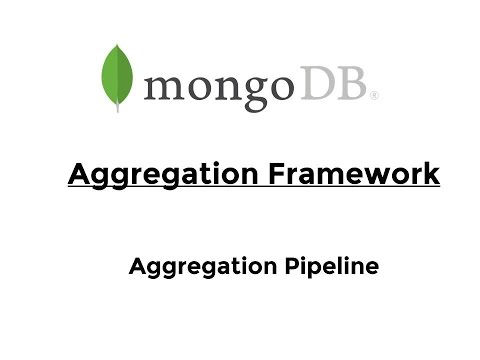

In [140]:
from IPython.display import YouTubeVideo
YouTubeVideo('VSX4a3h4SmQ',width=600)

Aqui tenemos un esquema con un ejemplo básico de agregación.

![](https://miro.medium.com/max/1060/1*2lDBxvZ8Cr3JYkoODTa0lQ.png)

## Algunos operadores de agregación



### `$match`

Este operador permite filtrar los documentos que queremos que pasen a la siguiente fase del pipeline definiendo una serie de condiciones sobre los campos de los mismos.

Vamos a filtrar aquellos documentos que tengan un `Score` igual o superior (`$gte`) a 40.

In [141]:
respuestas = posts.aggregate( [
        {'$match': { 'Score' : {'$gte': 40}}}
])
list(respuestas)

[{'_id': ObjectId('65e4537be6887c1fa367596a'),
  'Id': 1,
  'AcceptedAnswerId': 2,
  'AnswerCount': 1,
  'Body': '<p>Estoy creando un servicio usando <em>ASP.NET WebApi</em>. Quiero añadir soporte para la negociación del tipo de contenido basado en extensiones en el <em>URI</em>, así que he añadido lo siguiente al código de inicialización del servicio:</p><br/><br/><pre><code>public static class WebApiConfig<br/>{<br/>  public static void Register(HttpConfiguration config)<br/>  {<br/>    config.Formatters.JsonFormatter.AddUriPathExtensionMapping("json", "application/json");<br/>    config.Formatters.XmlFormatter.AddUriPathExtensionMapping("xml", "application/xml");<br/>  }<br/>}<br/></code></pre><br/><br/><p>Para que esto funcione necesito crear dos rutas para cada acción del controlador (estoy usando exclusivamente enrutamiento basado en atributos):</p><br/><br/><pre><code>[Route("item/{id}/details")]<br/>[Route("item/{id}/details.{ext}")]<br/>[HttpGet]<br/>public ItemDetail[] GetIte

### `$project`

El operador `$project`permite filtar qué campos de los documentos queremos usar en la siguientes fases de agregación.

Generalmente este operador suele combinarse con otros como `$find`, `$match` o `$lookup` en fases más avanzadas de la agregación.

En el siguiente ejemplo, realizamos un filtrado en donde solo nos quedamos con el campo `Id` de los posts.

In [142]:
respuestas = db['posts'].aggregate( [
    {'$project' : { 'Id' : True }},
    {'$limit': 20} ])
list(respuestas)

[{'_id': ObjectId('65e4537be6887c1fa367596a'), 'Id': 1},
 {'_id': ObjectId('65e4537be6887c1fa367596b'), 'Id': 2},
 {'_id': ObjectId('65e4537be6887c1fa367596c'), 'Id': 3},
 {'_id': ObjectId('65e4537be6887c1fa367596d'), 'Id': 4},
 {'_id': ObjectId('65e4537be6887c1fa367596e'), 'Id': 5},
 {'_id': ObjectId('65e4537be6887c1fa367596f'), 'Id': 6},
 {'_id': ObjectId('65e4537be6887c1fa3675970'), 'Id': 7},
 {'_id': ObjectId('65e4537be6887c1fa3675971'), 'Id': 8},
 {'_id': ObjectId('65e4537be6887c1fa3675972'), 'Id': 9},
 {'_id': ObjectId('65e4537be6887c1fa3675973'), 'Id': 10},
 {'_id': ObjectId('65e4537be6887c1fa3675974'), 'Id': 11},
 {'_id': ObjectId('65e4537be6887c1fa3675975'), 'Id': 12},
 {'_id': ObjectId('65e4537be6887c1fa3675976'), 'Id': 14},
 {'_id': ObjectId('65e4537be6887c1fa3675977'), 'Id': 15},
 {'_id': ObjectId('65e4537be6887c1fa3675978'), 'Id': 16},
 {'_id': ObjectId('65e4537be6887c1fa3675979'), 'Id': 17},
 {'_id': ObjectId('65e4537be6887c1fa367597a'), 'Id': 18},
 {'_id': ObjectId('65e4

### `$lookup`

El operador `$lookup` permite realizar búsquedas en otras colecciones. Podrían interpretarse como un `join` en el modelo relacional.

En el ejemplo siguiente, en primer lugar seleccionamos los posts con un `Score` igual o mayor a 40 con `$match` para a continuación seleccionar los usuarios que han publicado dichos posts incluyendolo en un nuevo campo llamado `owner`.

In [143]:
respuestas = posts.aggregate( [
        {'$match': { 'Score' : {'$gte': 40}}},
        {'$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"}
        }
        ])
list(respuestas)

[{'_id': ObjectId('65e4537be6887c1fa367596a'),
  'Id': 1,
  'AcceptedAnswerId': 2,
  'AnswerCount': 1,
  'Body': '<p>Estoy creando un servicio usando <em>ASP.NET WebApi</em>. Quiero añadir soporte para la negociación del tipo de contenido basado en extensiones en el <em>URI</em>, así que he añadido lo siguiente al código de inicialización del servicio:</p><br/><br/><pre><code>public static class WebApiConfig<br/>{<br/>  public static void Register(HttpConfiguration config)<br/>  {<br/>    config.Formatters.JsonFormatter.AddUriPathExtensionMapping("json", "application/json");<br/>    config.Formatters.XmlFormatter.AddUriPathExtensionMapping("xml", "application/xml");<br/>  }<br/>}<br/></code></pre><br/><br/><p>Para que esto funcione necesito crear dos rutas para cada acción del controlador (estoy usando exclusivamente enrutamiento basado en atributos):</p><br/><br/><pre><code>[Route("item/{id}/details")]<br/>[Route("item/{id}/details.{ext}")]<br/>[HttpGet]<br/>public ItemDetail[] GetIte

### `$arrayElemAt`

El `$lookup` genera un _array_ con todos los resultados. El operador `$arrayElementAt` accede al primer elemento.

In [144]:
respuestas = db.posts.aggregate( [
        {'$match': { 'Score' : {'$gte': 40}}},
        {'$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"}
        },
        { '$project' : {
            'Id' : True,
            'Score' : True,
            'username' : {'$arrayElemAt' : ['$owner.DisplayName', 0]},
            'owner.DisplayName' : True
          }}
        ])
list(respuestas)

[{'_id': ObjectId('65e4537be6887c1fa367596a'),
  'Id': 1,
  'Score': 40,
  'owner': [{'DisplayName': 'Konamiman'}],
  'username': 'Konamiman'},
 {'_id': ObjectId('65e4537be6887c1fa3675987'),
  'Id': 33,
  'Score': 79,
  'owner': [{'DisplayName': 'jachguate'}],
  'username': 'jachguate'},
 {'_id': ObjectId('65e4537be6887c1fa367598a'),
  'Id': 36,
  'Score': 141,
  'owner': [{'DisplayName': 'jachguate'}],
  'username': 'jachguate'},
 {'_id': ObjectId('65e4537be6887c1fa367598c'),
  'Id': 38,
  'Score': 44,
  'owner': [{'DisplayName': 'Carlos Muñoz'}],
  'username': 'Carlos Muñoz'},
 {'_id': ObjectId('65e4537be6887c1fa367598e'),
  'Id': 40,
  'Score': 206,
  'owner': [{'DisplayName': 'jachguate'}],
  'username': 'jachguate'},
 {'_id': ObjectId('65e4537be6887c1fa3675991'),
  'Id': 43,
  'Score': 41,
  'owner': [{'DisplayName': 'Angel Angel'}],
  'username': 'Angel Angel'},
 {'_id': ObjectId('65e4537be6887c1fa36759ad'),
  'Id': 90,
  'Score': 91,
  'owner': [{'DisplayName': 'Mosty Mostacho'}

### `$unwind`

Este operador *desdobla* cada fila por cada elemento del array.

Ej: El siguiente código

```python
db.inventory.insert_one({ "_id" : 1, "item" : "ABC1", "sizes": [ "S", "M", "L"] })
db.inventory.aggregate( [ { "$unwind" : "$sizes" } ] )
```

Devolverá:

```json
{ "_id" : 1, "item" : "ABC1", "sizes" : "S" }
{ "_id" : 1, "item" : "ABC1", "sizes" : "M" }
{ "_id" : 1, "item" : "ABC1", "sizes" : "L" }
```

En el ejemplo de procesamiento de posts que estamos llevando acabo, como sabemos que el array `$owner`sólo contiene un elemento, sólo habrá una fila por fila original, pero sin el _array_. Finalmente se puede proyectar el campo que se quiera. En este caso el `ownerDisplayName` que es proyectado (renombrado) como `username`.

In [145]:
respuestas = db.posts.aggregate( [
        { '$match': { 'Score' : {'$gte': 40}}},
        { '$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"
          }
        },
        { '$unwind': '$owner'},
        { '$project' : {
             'username': '$owner.DisplayName'
          }
        }
        ])
list(respuestas)

[{'_id': ObjectId('65e4537be6887c1fa367596a'), 'username': 'Konamiman'},
 {'_id': ObjectId('65e4537be6887c1fa3675987'), 'username': 'jachguate'},
 {'_id': ObjectId('65e4537be6887c1fa367598a'), 'username': 'jachguate'},
 {'_id': ObjectId('65e4537be6887c1fa367598c'), 'username': 'Carlos Muñoz'},
 {'_id': ObjectId('65e4537be6887c1fa367598e'), 'username': 'jachguate'},
 {'_id': ObjectId('65e4537be6887c1fa3675991'), 'username': 'Angel Angel'},
 {'_id': ObjectId('65e4537be6887c1fa36759ad'), 'username': 'Mosty Mostacho'},
 {'_id': ObjectId('65e4537be6887c1fa36759b1'), 'username': 'Jcl'},
 {'_id': ObjectId('65e4537be6887c1fa36759b9'), 'username': 'Mosty Mostacho'},
 {'_id': ObjectId('65e4537be6887c1fa36759df'), 'username': 'Mariano'},
 {'_id': ObjectId('65e4537be6887c1fa36759e2'), 'username': 'Hewbot'},
 {'_id': ObjectId('65e4537be6887c1fa36759e5'), 'username': 'Hewbot'},
 {'_id': ObjectId('65e4537be6887c1fa36759e8'), 'username': 'Carlos Muñoz'},
 {'_id': ObjectId('65e4537be6887c1fa36759f6'), 

### `$push`

Devuelve un array con *todos* los valores que resultan de aplicar una determinada expresión a los documentos que forman parte del pipeline.

Obtener el listado con el identificador de `Posts` (`Id`) asociados a cada valor de `Score`.

In [146]:
posts_by_score= db.posts.aggregate([
    {
        '$group':{
            '_id': '$Score',
            'posts':{
                '$push': {
                    'post': '$Id'
                }
            }
        }
    }

])
list(posts_by_score)

[{'_id': -28, 'posts': [{'post': 54916}]},
 {'_id': -14, 'posts': [{'post': 54917}]},
 {'_id': -12, 'posts': [{'post': 98793}]},
 {'_id': -10, 'posts': [{'post': 16994}]},
 {'_id': -9, 'posts': [{'post': 79321}, {'post': 442176}]},
 {'_id': -8,
  'posts': [{'post': 175},
   {'post': 40463},
   {'post': 90789},
   {'post': 104149},
   {'post': 106950},
   {'post': 228255},
   {'post': 229978},
   {'post': 250535},
   {'post': 275012},
   {'post': 393887}]},
 {'_id': -7,
  'posts': [{'post': 16706},
   {'post': 23894},
   {'post': 40218},
   {'post': 65300},
   {'post': 82961},
   {'post': 87472},
   {'post': 93682},
   {'post': 95036},
   {'post': 124142},
   {'post': 124762},
   {'post': 140045},
   {'post': 142166},
   {'post': 154869},
   {'post': 224603},
   {'post': 258846},
   {'post': 336381},
   {'post': 355008},
   {'post': 423240}]},
 {'_id': -6,
  'posts': [{'post': 15249},
   {'post': 72726},
   {'post': 74038},
   {'post': 82620},
   {'post': 92028},
   {'post': 131535},
  

### `$addToSet`

 Devuelve un array de todos los valores únicos que resultan de aplicar una expresión a cada documento de un grupo.


Vamos a obtener el listado de `Tags` asociadas a cada tipo de licencia  `ContentLicense`.

In [147]:
license_and_tags= db.posts.aggregate([
            { "$match" : {"PostTypeId": 1}},
            {"$limit": 10},

             {'$group':{
                             '_id':'$ContentLicense',
                             'AllTags': { '$addToSet': "$Tags" }
            }}

            ]
)
list(license_and_tags)

[{'_id': 'CC BY-SA 4.0', 'AllTags': ['<.net><asp.net-web-api><asp.net>']},
 {'_id': 'CC BY-SA 3.0',
  'AllTags': ['<google-maps><angularjs><jasmine><karma-jasmine>',
   '<lista><elixir>',
   '<delphi>',
   '<c++><casting>',
   '<ruby-on-rails><ruby><vistas>',
   '<typescript>',
   '<array><perl>',
   '<ios><xcode>',
   '<c++><string>']}]

### `$out`

Este comando permite volcar el ersulado de un pipeline de agregación en una nueva colección en la base de datos.

In [148]:
respuestas = db.posts.aggregate( [
        { '$match': { 'Score' : {'$gte': 40}}},
        { '$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"
          }
        },
        { '$unwind': '$owner'},
        { '$project' : {
             'username': '$owner.DisplayName'
          }
        },
        {'$out': "stackoverflow_users"}
        ])

In [149]:
db.stackoverflow_users.count_documents({})

122

## Ejemplos básicos de agregación

### Ejemplo 1: Asociación usuarios con Tags

Con Agregación, vamos a construir una colección que asocia un usuario con los tags que ha usado en todas sus preguntas.

*Por cuestiones de rendimiento vamos a limitar la agregación a 50 elementos.*

In [150]:
user_tags= db.posts.aggregate( [
        { "$match" : {"PostTypeId": 1}},

        {"$limit": 50},

        { '$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"
          }
        },

        {'$project':{
            'Tags': True,
            'userid' : {'$arrayElemAt' : ['$owner.Id', 0]},
        }},

        {'$group':{
            '_id':'$userid',
            'AllTags': { '$addToSet': "$Tags" }
        }}
]
)

user_tags_lst= list(user_tags)
user_tags_lst

[{'_id': 302, 'AllTags': ['<pharo><smalltalk>', '<archivo><fish><exists>']},
 {'_id': 22, 'AllTags': ['<array><perl>']},
 {'_id': 35,
  'AllTags': ['<asp.net><asp.net-mvc><librería><bower>',
   '<javascript><kendoui><knockoutjs>']},
 {'_id': 20, 'AllTags': ['<typescript>']},
 {'_id': 25, 'AllTags': ['<javascript>', '<git>']},
 {'_id': 187, 'AllTags': ['<mysql><java><spring><hibernate>']},
 {'_id': 149, 'AllTags': ['<string><c#>']},
 {'_id': 260, 'AllTags': ['<java>', '<html><css>', '<git><git-commit>']},
 {'_id': 127, 'AllTags': ['<javascript><validación><email><regex>']},
 {'_id': 261, 'AllTags': ['<java><try-catch>']},
 {'_id': 399, 'AllTags': ['<mysql><vagrant><puppet>']},
 {'_id': 29,
  'AllTags': ['<api><ruby><http><post>', '<ruby-on-rails><ruby><vistas>']},
 {'_id': 218, 'AllTags': ['<python><variables>']},
 {'_id': 342,
  'AllTags': ['<java><eclipse><depuración><jboss>',
   '<java><dukescript><admob>']},
 {'_id': 217,
  'AllTags': ['<poo><funciones><estándares>', '<string><php><

### Ejemplo 2: Asociación Tags con usuarios

Ahora, dado un ID de tag, qué usuarios han hecho preguntas de ese tag.

*De nuevo limitamos la búsqueda a 50 documentos*

In [151]:
tags_users= db.posts.aggregate( [
        { "$match" : {"PostTypeId": 1}},

        {"$limit": 50},

        { '$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"
          }
        },

        {'$project':{
            'Tags': True,
            'userid' : {'$arrayElemAt' : ['$owner.Id', 0]},
        }},

        {'$group':{
            '_id':'$Tags',
            'AllUsers': { '$addToSet': "$userid" }
        }}
]
)

tags_users_lst= list(tags_users)
tags_users_lst

[{'_id': '<javascript>', 'AllUsers': [25]},
 {'_id': '<c++><string>', 'AllUsers': [24]},
 {'_id': '<git><git-commit>', 'AllUsers': [83, 260]},
 {'_id': '<delphi>', 'AllUsers': [21]},
 {'_id': '<lista><elixir>', 'AllUsers': [37]},
 {'_id': '<c#>', 'AllUsers': [72]},
 {'_id': '<php><ajax><laravel><laravel-5>', 'AllUsers': [73]},
 {'_id': '<string><c#>', 'AllUsers': [149]},
 {'_id': '<soap><soapui><wcf><servicio>', 'AllUsers': [325]},
 {'_id': '<html><css>', 'AllUsers': [260]},
 {'_id': '<string><php><str-replace>', 'AllUsers': [217]},
 {'_id': '<java>', 'AllUsers': [260]},
 {'_id': '<java><eclipse><depuración><jboss>', 'AllUsers': [342]},
 {'_id': '<bash><linux><shell><sed><awk>', 'AllUsers': [83]},
 {'_id': '<archivo><fish><exists>', 'AllUsers': [302]},
 {'_id': '<poo><funciones><estándares>', 'AllUsers': [217]},
 {'_id': '<javascript><jquery>', 'AllUsers': [21]},
 {'_id': '<ios><xcode>', 'AllUsers': [37, 233]},
 {'_id': '<.net><asp.net-web-api><asp.net>', 'AllUsers': [23]},
 {'_id': '<

## Ejercicios

### EJ1: Obtener un una colección de documentos *verbosos* en donde se indique el texto `Body` de una pregunta así como el nombre del usuario que la formuló (`DisplayName`)

### EJ2: Obtener las respuestas escritas en el mes de Enero de 2022 con un `Score` superior a 3

In [152]:
print("Eso es todo amigos!")

Eso es todo amigos!
